In [1]:
 sc.applicationId

'local-1638994761868'

# Tien xu li du lieu

In [2]:
from pyspark.sql.functions import isnan,isnull,when,count,col,countDistinct,explode,array,struct,lit
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from typing import Iterable 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data = sqlContext.read.format('com.databricks.spark.csv')\
       .option('header', 'true')\
       .option('delimiter', ',').load("/home/huan/Downloads/train.csv")

In [4]:
data = data.select([F.col(col).alias(col.replace(' ', '_')) for col in data.columns])

In [5]:
#So dong du lieu
data.count()

103904

In [6]:
# kiem tra missing value
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

21/12/08 12:19:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, Gender, Customer Type, Age, Type of Travel, Class, Flight Distance, Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness, Departure Delay in Minutes, Arrival Delay in Minutes, satisfaction
 Schema: _c0, id, Gender, Customer Type, Age, Type of Travel, Class, Flight Distance, Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness, Departure Delay in Minutes, Arrival Delay in Minutes, satisfaction
Expected: _c0 but found: 
CSV file: file:///home/huan/Downloads/train.csv

+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0| id|Gender|Customer_Type|Age|Type_of_Travel|Class|Flight_Distance|Inflight_wifi_service|Departure/Arrival_time_convenient|Ease_of_Online_booking|Gate_location|Food_and_drink|Online_boarding|Seat_comfort|Inflight_entertainment|On-board_service|Leg_room_service|Baggage_handling|Checkin_service|Inflight_service|Cleanliness|Departure_Delay_in_Minutes|Arrival_Delay_in_Minutes|satisfaction|
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+------

In [7]:
data.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in data.columns]).toPandas()

21/12/08 12:19:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, Gender, Customer Type, Age, Type of Travel, Class, Flight Distance, Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness, Departure Delay in Minutes, Arrival Delay in Minutes, satisfaction
 Schema: _c0, id, Gender, Customer Type, Age, Type of Travel, Class, Flight Distance, Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness, Departure Delay in Minutes, Arrival Delay in Minutes, satisfaction
Expected: _c0 but found: 
CSV file: file:///home/huan/Downloads/train.csv

,_c0,id,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,310,0


In [8]:
# xoa cot khong co y nghia
data = data.drop(*["_c0","id"])
# Dien missing value boi mean ( mean duoc tinh ben duoi)
data = data.fillna({"Arrival_Delay_in_Minutes":0})

In [9]:
data.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in data.columns]).toPandas()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Cau truc du lieu:
data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Type_of_Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight_Distance: string (nullable = true)
 |-- Inflight_wifi_service: string (nullable = true)
 |-- Departure/Arrival_time_convenient: string (nullable = true)
 |-- Ease_of_Online_booking: string (nullable = true)
 |-- Gate_location: string (nullable = true)
 |-- Food_and_drink: string (nullable = true)
 |-- Online_boarding: string (nullable = true)
 |-- Seat_comfort: string (nullable = true)
 |-- Inflight_entertainment: string (nullable = true)
 |-- On-board_service: string (nullable = true)
 |-- Leg_room_service: string (nullable = true)
 |-- Baggage_handling: string (nullable = true)
 |-- Checkin_service: string (nullable = true)
 |-- Inflight_service: string (nullable = true)
 |-- Cleanliness: string (nullable = true)
 |-- Departure_Delay_in_Minutes: string (nullable = true)

In [11]:
#convert datatype to int
data = data.withColumn('Age',data['Age'].cast('int'))
data = data.withColumn('Flight_Distance',data['Flight_Distance'].cast('int'))
data = data.withColumn('Inflight_wifi_service',data['Inflight_wifi_service'].cast('int'))
data = data.withColumn('Departure/Arrival_time_convenient',data['Departure/Arrival_time_convenient'].cast('int'))
data = data.withColumn('Ease_of_Online_booking',data['Ease_of_Online_booking'].cast('int'))
data = data.withColumn('Gate_location',data['Gate_location'].cast('int'))
data = data.withColumn('Food_and_drink',data['Food_and_drink'].cast('int'))
data = data.withColumn('Online_boarding',data['Online_boarding'].cast('int'))
data = data.withColumn('Seat_comfort',data['Seat_comfort'].cast('int'))
data = data.withColumn('On-board_service',data['On-board_service'].cast('int'))
data = data.withColumn('Leg_room_service',data['Leg_room_service'].cast('int'))
data = data.withColumn('Baggage_handling',data['Baggage_handling'].cast('int'))
data = data.withColumn('Checkin_service',data['Checkin_service'].cast('int'))
data = data.withColumn('Inflight_service',data['Inflight_service'].cast('int'))
data = data.withColumn('Cleanliness',data['Cleanliness'].cast('int'))
data = data.withColumn('Departure_Delay_in_Minutes',data['Departure_Delay_in_Minutes'].cast('int'))
data = data.withColumn('Inflight_entertainment',data['Inflight_entertainment'].cast('int'))
data = data.withColumn('Arrival_Delay_in_Minutes',data['Arrival_Delay_in_Minutes'].cast('int'))


In [12]:
data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type_of_Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight_Distance: integer (nullable = true)
 |-- Inflight_wifi_service: integer (nullable = true)
 |-- Departure/Arrival_time_convenient: integer (nullable = true)
 |-- Ease_of_Online_booking: integer (nullable = true)
 |-- Gate_location: integer (nullable = true)
 |-- Food_and_drink: integer (nullable = true)
 |-- Online_boarding: integer (nullable = true)
 |-- Seat_comfort: integer (nullable = true)
 |-- Inflight_entertainment: integer (nullable = true)
 |-- On-board_service: integer (nullable = true)
 |-- Leg_room_service: integer (nullable = true)
 |-- Baggage_handling: integer (nullable = true)
 |-- Checkin_service: integer (nullable = true)
 |-- Inflight_service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure_Delay_in_Minutes: integer 

In [13]:
data.take(2)

[Row(Gender='Male', Customer_Type='Loyal Customer', Age=13, Type_of_Travel='Personal Travel', Class='Eco Plus', Flight_Distance=460, Inflight_wifi_service=3, Departure/Arrival_time_convenient=4, Ease_of_Online_booking=3, Gate_location=1, Food_and_drink=5, Online_boarding=3, Seat_comfort=5, Inflight_entertainment=5, On-board_service=4, Leg_room_service=3, Baggage_handling=4, Checkin_service=4, Inflight_service=5, Cleanliness=5, Departure_Delay_in_Minutes=25, Arrival_Delay_in_Minutes=18, satisfaction='neutral or dissatisfied'),
 Row(Gender='Male', Customer_Type='disloyal Customer', Age=25, Type_of_Travel='Business travel', Class='Business', Flight_Distance=235, Inflight_wifi_service=3, Departure/Arrival_time_convenient=2, Ease_of_Online_booking=3, Gate_location=3, Food_and_drink=1, Online_boarding=3, Seat_comfort=1, Inflight_entertainment=1, On-board_service=1, Leg_room_service=5, Baggage_handling=3, Checkin_service=1, Inflight_service=4, Cleanliness=1, Departure_Delay_in_Minutes=1, Arri

In [14]:
#summary statistic for numeric variables
# data.describe().show()
# su dung pandas de de dang xem ket qua
data.toPandas().describe()

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [15]:
#median 
string_columns =[item[0] for item in data.dtypes if item[1].startswith('string')]
for col in data.columns:
    if not col in string_columns:
        medi = np.median(data.select(col).rdd.flatMap(lambda x:x).collect())
        print("Median of ", col,":", medi)

Median of  Age : 40.0
Median of  Flight_Distance : 843.0
Median of  Inflight_wifi_service : 3.0
Median of  Departure/Arrival_time_convenient : 3.0
Median of  Ease_of_Online_booking : 3.0


Median of  Gate_location : 3.0
Median of  Food_and_drink : 3.0
Median of  Online_boarding : 3.0
Median of  Seat_comfort : 4.0
Median of  Inflight_entertainment : 4.0
Median of  On-board_service : 4.0
Median of  Leg_room_service : 4.0
Median of  Baggage_handling : 4.0
Median of  Checkin_service : 3.0
Median of  Inflight_service : 4.0
Median of  Cleanliness : 3.0
Median of  Departure_Delay_in_Minutes : 0.0
Median of  Arrival_Delay_in_Minutes : 0.0


In [16]:
string_columns =[item[0] for item in data.dtypes if item[1].startswith('string')]
for col in data.columns:
    if not col in string_columns:
        medi = np.min(data.select(col).rdd.flatMap(lambda x:x).collect())
        print("min of ", col,":", medi)

min of  Age : 7
min of  Flight_Distance : 31
min of  Inflight_wifi_service : 0
min of  Departure/Arrival_time_convenient : 0
min of  Ease_of_Online_booking : 0
min of  Gate_location : 0
min of  Food_and_drink : 0
min of  Online_boarding : 0
min of  Seat_comfort : 0
min of  Inflight_entertainment : 0
min of  On-board_service : 0
min of  Leg_room_service : 0
min of  Baggage_handling : 1
min of  Checkin_service : 0
min of  Inflight_service : 0
min of  Cleanliness : 0
min of  Departure_Delay_in_Minutes : 0
min of  Arrival_Delay_in_Minutes : 0


In [17]:
string_columns =[item[0] for item in data.dtypes if item[1].startswith('string')]
for col in data.columns:
    if not col in string_columns:
        medi = np.mean(data.select(col).rdd.flatMap(lambda x:x).collect())
        print("Mean of ", col,":", medi)

Mean of  Age : 39.379706267323684
Mean of  Flight_Distance : 1189.4483754234677
Mean of  Inflight_wifi_service : 2.72968316907915
Mean of  Departure/Arrival_time_convenient : 3.06029604250077
Mean of  Ease_of_Online_booking : 2.7569006005543577
Mean of  Gate_location : 2.9768825069294733
Mean of  Food_and_drink : 3.2021288882044963
Mean of  Online_boarding : 3.250375346473668
Mean of  Seat_comfort : 3.4393959809054513
Mean of  Inflight_entertainment : 3.358157530027718
Mean of  On-board_service : 3.382362565445026
Mean of  Leg_room_service : 3.3510548198336925
Mean of  Baggage_handling : 3.6318332306744687
Mean of  Checkin_service : 3.304290498922082
Mean of  Inflight_service : 3.6404277024946103
Mean of  Cleanliness : 3.2863508623344626
Mean of  Departure_Delay_in_Minutes : 14.815618263012011
Mean of  Arrival_Delay_in_Minutes : 15.133392362180475


In [18]:
string_columns =[item[0] for item in data.dtypes if item[1].startswith('string')]
for col in data.columns:
    if not col in string_columns:
        medi = np.max(data.select(col).rdd.flatMap(lambda x:x).collect())
        print("Max of ", col,":", medi)

Max of  Age : 85
Max of  Flight_Distance : 4983
Max of  Inflight_wifi_service : 5
Max of  Departure/Arrival_time_convenient : 5
Max of  Ease_of_Online_booking : 5
Max of  Gate_location : 5
Max of  Food_and_drink : 5
Max of  Online_boarding : 5
Max of  Seat_comfort : 5
Max of  Inflight_entertainment : 5
Max of  On-board_service : 5
Max of  Leg_room_service : 5
Max of  Baggage_handling : 5
Max of  Checkin_service : 5
Max of  Inflight_service : 5
Max of  Cleanliness : 5
Max of  Departure_Delay_in_Minutes : 1592
Max of  Arrival_Delay_in_Minutes : 1584


# Visualization Datasets

Phân phối của số lượng khách đối với mỗi lứa tuổi

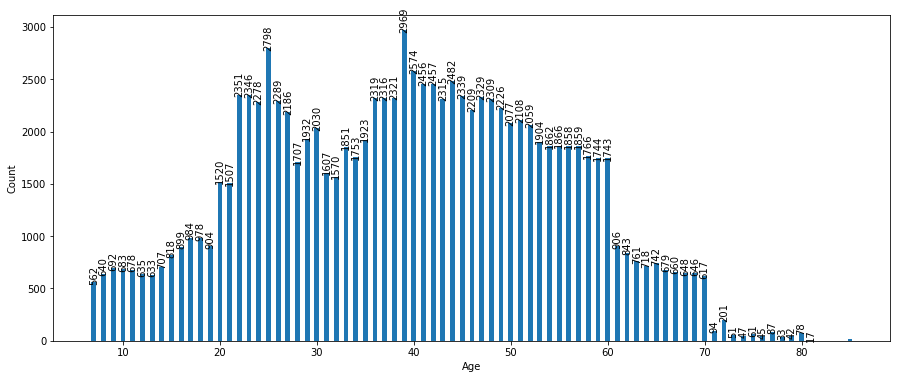

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sum_age = data.groupBy('Age').count().sort("Age").collect()
age_count = list(map(lambda x: int(x[0]), sum_age))
class_count = list(map(lambda x: x[1],sum_age))

index = np.arange(len(age_count))

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.bar(age_count, class_count, align='center', width=0.5)
for i,v in enumerate(class_count):
    plt.text(x=i+7, y = v  ,s=f"{v}", fontdict=dict(fontsize=10),rotation='vertical', ha='center' )
plt.show()

In [16]:
# def ChartCountPlot(data,x_axis,hue):
#     plt.figure(figsize=(20,10))
#     sns.countplot(x_axis,data=data,hue=hue)
#     plt.title("Chart of "+x_axis +" by "+hue)
#     plt.show()

In [17]:
dt_pd = data.toPandas()

/home/huan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


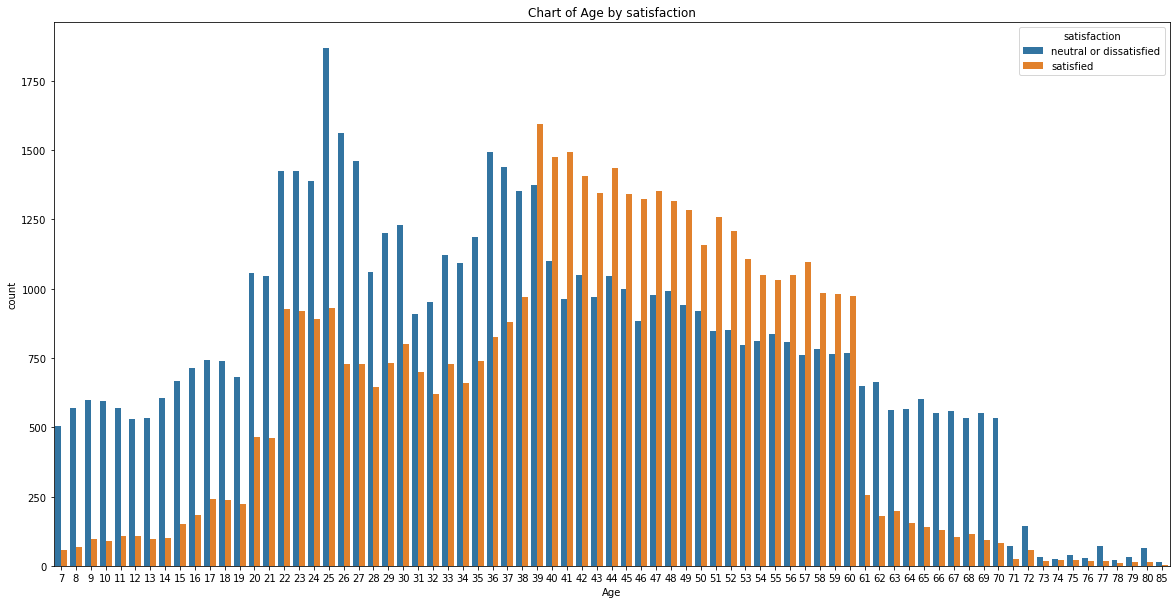

In [18]:
ChartCountPlot(dt_pd,'Age','satisfaction')

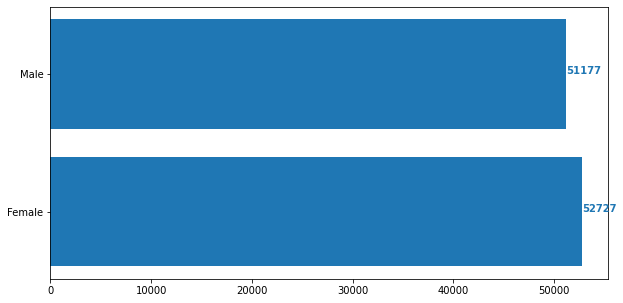

In [19]:
gender_count = data.groupBy('Gender').count().collect()
gender_ = list(map(lambda x: x[0],gender_count))
count_ = list(map(lambda x: int(x[1]),gender_count))

fig, ax = plt.subplots(figsize=(10,5))
ind = np.arange(len(count_))
for i, v in enumerate(count_):
    ax.text(v + 3, i, str(v), fontweight='bold', color='C0')
    ax.barh(ind, count_, color = 'C0')
    ax.set_yticks(ind)
    ax.set_yticklabels(gender_)
    plt.show

Thống kê thuộc tính X gom theo thuộc tính Hài lòng

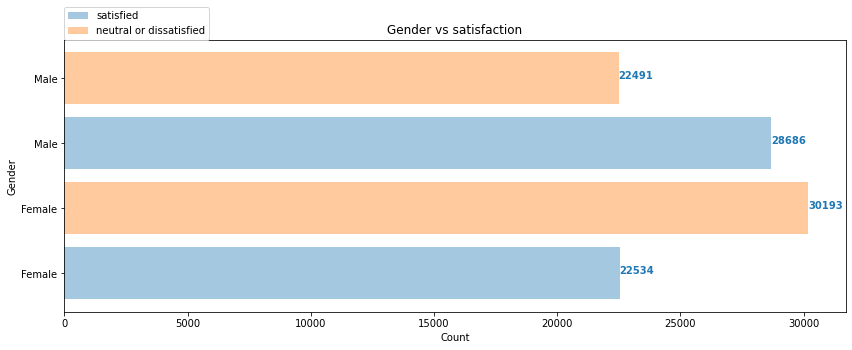

In [20]:
satisfaction = data.groupBy('Gender', 'satisfaction').count().sort('Gender').collect()
gender_ = list(map(lambda x: x[0],satisfaction))
satisfaction_ = list(map(lambda x: x[1],satisfaction))
count_ = list(map(lambda x: int(x[2]),satisfaction))


y_pos = np.arange(len(gender_))
error = np.random.rand(len(gender_))
clr = ('C0', 'C1')
fig, ax = plt.subplots(figsize=(14,5))
h = ax.barh(y_pos, count_, xerr=error, align='center', 
alpha=0.4, label=gender_, color=clr)
plt.yticks(y_pos, gender_)
ax.set_title('Gender vs satisfaction')
plt.xlabel('Count')
plt.ylabel('Gender')
plt.legend(h,set(satisfaction_), loc=(0,1)
          )
for i,v in enumerate(count_):
    ax.text(v + 3, i, str(v), fontweight='bold', color='C0')
plt.show()

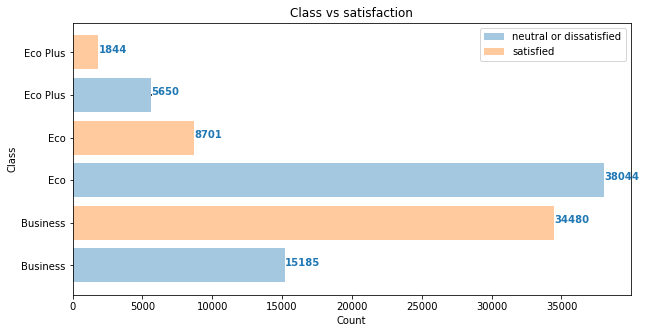

In [21]:
satisfaction = data.groupBy('Class', 'satisfaction').count().sort('Class').collect()
class_ = list(map(lambda x: x[0],satisfaction))
satisfaction_ = list(map(lambda x: x[1],satisfaction))
count_ = list(map(lambda x: int(x[2]),satisfaction))


y_pos = np.arange(len(class_))
error = np.random.rand(len(class_))
clr = ('C0', 'C1')
fig, ax = plt.subplots(figsize=(10,5))
h = ax.barh(y_pos, count_, xerr=error, align='center', 
alpha=0.4, label=class_, color=clr)
plt.yticks(y_pos, class_)
ax.set_title('Class vs satisfaction')
plt.xlabel('Count')
plt.ylabel('Class')
plt.legend(h,sorted(set(satisfaction_)))
for i,v in enumerate(count_):
    ax.text(v + 3, i, str(v), fontweight='bold', color='C0')
plt.show()

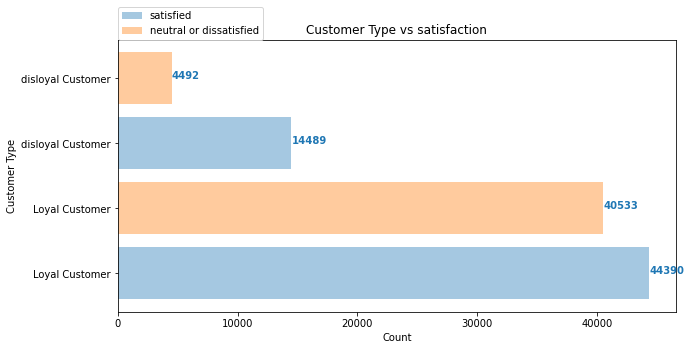

In [22]:
satisfaction = data.groupBy('Customer_Type', 'satisfaction').count().sort('Customer_Type').collect()
gender_ = list(map(lambda x: x[0],satisfaction))
satisfaction_ = list(map(lambda x: x[1],satisfaction))
count_ = list(map(lambda x: int(x[2]),satisfaction))


y_pos = np.arange(len(gender_))
error = np.random.rand(len(gender_))
clr = ('C0', 'C1')
fig, ax = plt.subplots(figsize=(10,5))
h = ax.barh(y_pos, count_, xerr=error, align='center', 
alpha=0.4, label=gender_, color=clr)
plt.yticks(y_pos, gender_)
ax.set_title('Customer Type vs satisfaction')
plt.xlabel('Count')
plt.ylabel('Customer Type')
plt.legend(h,set(satisfaction_), loc=(0,1)
          )
for i,v in enumerate(count_):
    ax.text(v + 3, i, str(v), fontweight='bold', color='C0')
plt.show()

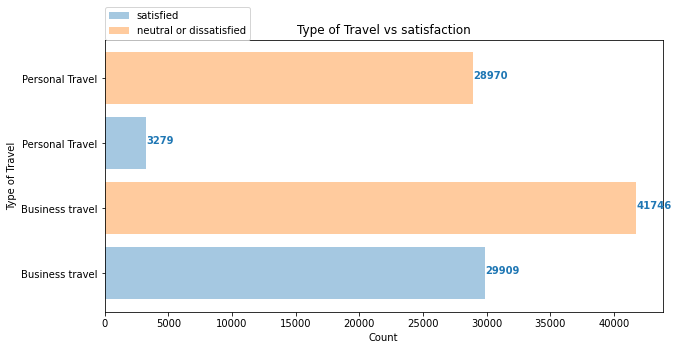

In [27]:
satisfaction = data.groupBy('Type_of_Travel', 'satisfaction').count().sort('Type_of_Travel').collect()
gender_ = list(map(lambda x: x[0],satisfaction))
satisfaction_ = list(map(lambda x: x[1],satisfaction))
count_ = list(map(lambda x: int(x[2]),satisfaction))


y_pos = np.arange(len(gender_))
error = np.random.rand(len(gender_))
clr = ('C0', 'C1')
fig, ax = plt.subplots(figsize=(10,5))
h = ax.barh(y_pos, count_, xerr=error, align='center', 
alpha=0.4, label=gender_, color=clr)
plt.yticks(y_pos, gender_)
ax.set_title('Type of Travel vs satisfaction')
plt.xlabel('Count')
plt.ylabel('Type of Travel')
plt.legend(h,set(satisfaction_), loc=(0,1)
          )
for i,v in enumerate(count_):
    ax.text(v + 3, i, str(v), fontweight='bold', color='C0')
plt.show()

/home/huan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/huan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


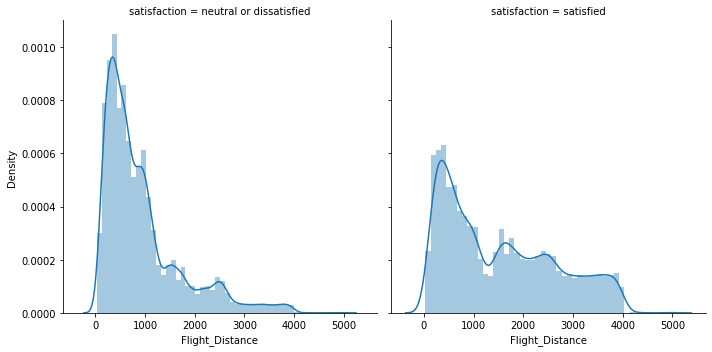

In [28]:
G=sns.FacetGrid(data=data.toPandas(), col='satisfaction',height=5)
G.map(sns.distplot, 'Flight_Distance')
plt.show()


/home/huan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/huan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


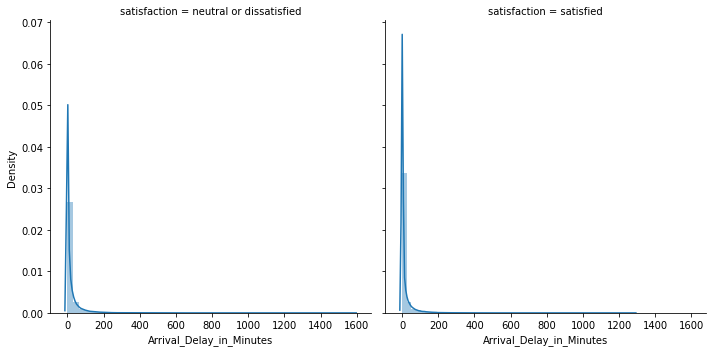

In [29]:
G=sns.FacetGrid(data=data.toPandas(), col='satisfaction',height=5)
G.map(sns.distplot, 'Arrival_Delay_in_Minutes')
plt.show()

In [23]:
data.columns

['Gender',
 'Customer_Type',
 'Age',
 'Type_of_Travel',
 'Class',
 'Flight_Distance',
 'Inflight_wifi_service',
 'Departure/Arrival_time_convenient',
 'Ease_of_Online_booking',
 'Gate_location',
 'Food_and_drink',
 'Online_boarding',
 'Seat_comfort',
 'Inflight_entertainment',
 'On-board_service',
 'Leg_room_service',
 'Baggage_handling',
 'Checkin_service',
 'Inflight_service',
 'Cleanliness',
 'Departure_Delay_in_Minutes',
 'Arrival_Delay_in_Minutes',
 'satisfaction']

Xử lí thuộc tính tương đồng cao

<AxesSubplot:>

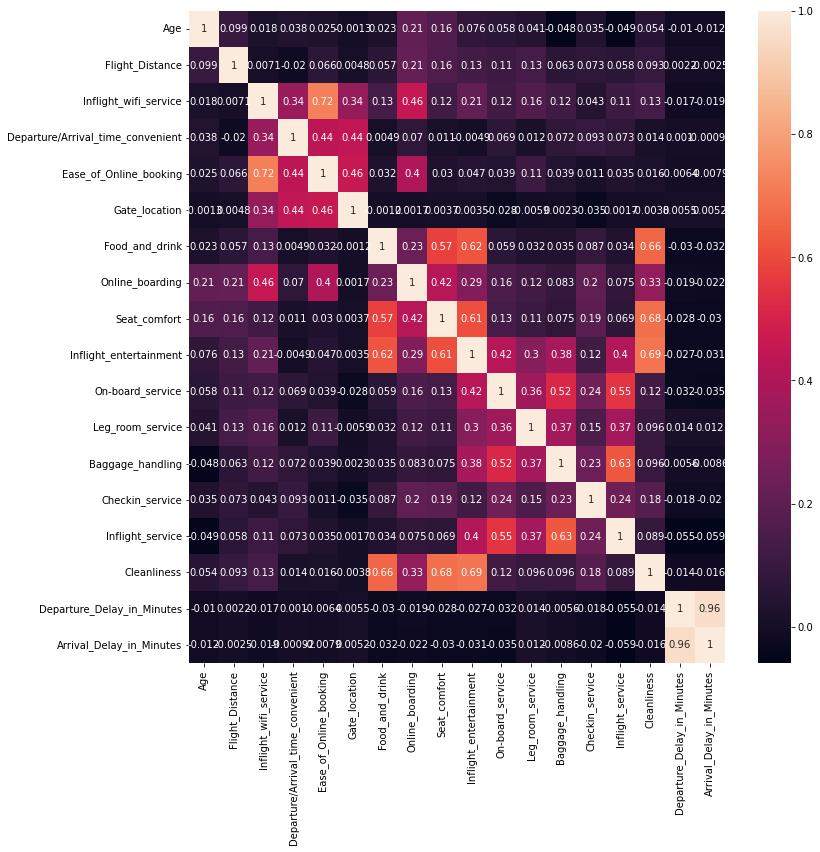

In [24]:
plt.figure(figsize=(12,12))
sns.heatmap(data.toPandas().corr(method='pearson'), annot=True)

In [25]:
data = data.drop("Departure_Delay_in_Minutes")
data = data.drop("Ease_of_Online_booking")

In [26]:
data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type_of_Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight_Distance: integer (nullable = true)
 |-- Inflight_wifi_service: integer (nullable = true)
 |-- Departure/Arrival_time_convenient: integer (nullable = true)
 |-- Gate_location: integer (nullable = true)
 |-- Food_and_drink: integer (nullable = true)
 |-- Online_boarding: integer (nullable = true)
 |-- Seat_comfort: integer (nullable = true)
 |-- Inflight_entertainment: integer (nullable = true)
 |-- On-board_service: integer (nullable = true)
 |-- Leg_room_service: integer (nullable = true)
 |-- Baggage_handling: integer (nullable = true)
 |-- Checkin_service: integer (nullable = true)
 |-- Inflight_service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Arrival_Delay_in_Minutes: integer (nullable = true)
 |-- satisfaction: string (nullable = t

In [34]:
# def Balance(data):
#     Range = int(len(data[data['satisfaction']=='neutral or dissatisfied'])) - int(len(data[data['satisfaction']=='satisfied']))
#     if Range >0:
#         index = data[data['satisfaction'] == 'neutral or dissatisfied'].index.values
#         index = index.tolist()
#         array = random.sample(index, Range)
#         data = data.drop(labels=array, axis=0)
#     else:
#             index = data[data['satisfaction'] == 'satisfied'].index.values
#             index = index.tolist()
#             array = random.sample(index, -Range)
#             data = data.drop(labels=array, axis=0)
#     return data

Tính Min, Max, Median của thuộc tính numeric

In [27]:
row_max = data.agg({'Age': 'max'},).collect()[0]
maxx = row_max['max(Age)']
row_min = data.agg({'Age': 'min'},).collect()[0]
minn = row_min['min(Age)']
#so gio = 10
dorong=(maxx-minn)/10
print(maxx,minn,dorong)

85 7 7.8


In [28]:
data = data.withColumn('Age', when(data.Age <15 ,"[7..15)") \
                           .when(data.Age <23,"[15..23)") \
                           .when(data.Age <31,"[23..31)") \
                           .when(data.Age <39,"[31..39)") \
                           .when(data.Age <47,"[39..47)") \
                           .when(data.Age <55,"[47..55)") \
                           .when(data.Age <63,"[55..63)") \
                           .when(data.Age <71,"[63..71)") \
                           .when(data.Age <79,"[71..79)") \
                           .otherwise("[79..)"))
data.select(data['Age']).collect()

[Row(Age='[7..15)'),
 Row(Age='[23..31)'),
 Row(Age='[23..31)'),
 Row(Age='[23..31)'),
 Row(Age='[55..63)'),
 Row(Age='[23..31)'),
 Row(Age='[47..55)'),
 Row(Age='[47..55)'),
 Row(Age='[39..47)'),
 Row(Age='[15..23)'),
 Row(Age='[23..31)'),
 Row(Age='[7..15)'),
 Row(Age='[47..55)'),
 Row(Age='[31..39)'),
 Row(Age='[23..31)'),
 Row(Age='[7..15)'),
 Row(Age='[23..31)'),
 Row(Age='[39..47)'),
 Row(Age='[39..47)'),
 Row(Age='[31..39)'),
 Row(Age='[7..15)'),
 Row(Age='[15..23)'),
 Row(Age='[39..47)'),
 Row(Age='[55..63)'),
 Row(Age='[23..31)'),
 Row(Age='[55..63)'),
 Row(Age='[31..39)'),
 Row(Age='[47..55)'),
 Row(Age='[31..39)'),
 Row(Age='[15..23)'),
 Row(Age='[31..39)'),
 Row(Age='[15..23)'),
 Row(Age='[31..39)'),
 Row(Age='[63..71)'),
 Row(Age='[31..39)'),
 Row(Age='[39..47)'),
 Row(Age='[31..39)'),
 Row(Age='[39..47)'),
 Row(Age='[47..55)'),
 Row(Age='[39..47)'),
 Row(Age='[39..47)'),
 Row(Age='[23..31)'),
 Row(Age='[39..47)'),
 Row(Age='[31..39)'),
 Row(Age='[47..55)'),
 Row(Age='[23.

In [29]:
# data.groupBy('Age').count().show()

In [30]:
row_max = data.agg({'Flight_Distance': 'max'},).collect()[0]
maxx = row_max['max(Flight_Distance)']
row_min = data.agg({'Flight_Distance': 'min'},).collect()[0]
minn = row_min['min(Flight_Distance)']
#so gio = 10
dorong=(maxx-minn)/10
print("do rong:",dorong)

do rong: 495.2


In [31]:
data = data.withColumn('Flight_Distance', when(data['Flight_Distance'] <526 ,"[31...526)") \
                           .when(data['Flight_Distance'] <  1021,"[526...1021)") \
                           .when(data['Flight_Distance'] <  1516,"[1021...1516)") \
                           .when(data['Flight_Distance'] <  2011,"[1516...2011)") \
                           .when(data['Flight_Distance'] <  2506,"[2011...2506)") \
                           .when(data['Flight_Distance'] <  3001 ,"[2506...3001)") \
                           .when(data['Flight_Distance'] <  3496,"[3001...3496)") \
                           .when(data['Flight_Distance'] <  3991,"[3496...3991)") \
                           .when(data['Flight_Distance'] <  4486,"[3991...4486)") \
                           .otherwise("[4486...)"))
data.select(data['Flight_Distance']).collect()

[Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[1021...1516)'),
 Row(Flight_Distance='[526...1021)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[1021...1516)'),
 Row(Flight_Distance='[1021...1516)'),
 Row(Flight_Distance='[2011...2506)'),
 Row(Flight_Distance='[526...1021)'),
 Row(Flight_Distance='[1021...1516)'),
 Row(Flight_Distance='[1021...1516)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[526...1021)'),
 Row(Flight_Distance='[526...1021)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[2011...2506)'),
 Row(Flight_Distance='[2011...2506)'),
 Row(Flight_Distance='[2011...2506)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[1021...1516)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[526...1021)'),
 Row(Flight_Distance='[2011...2506)'),
 Row(Flight_Distance='[31...526)'),
 Row(Flight_Distance='[526...1021)'),
 Row(Flight_Distanc

Rời rạc hóa dữ liệu

In [32]:
row_max = data.agg({'Arrival_Delay_in_Minutes': 'max'},).collect()[0]
maxx = row_max['max(Arrival_Delay_in_Minutes)']
row_min = data.agg({'Arrival_Delay_in_Minutes': 'min'},).collect()[0]
minn = row_min['min(Arrival_Delay_in_Minutes)']
dorong=(maxx-minn)/10
print(maxx, minn ,dorong)

1584 0 158.4


In [33]:
data = data.withColumn('Arrival_Delay_in_Minutes', when(data['Arrival_Delay_in_Minutes'] <1 ,"[..0)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  1021,"[1..159)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  1516,"[159...317)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  2011,"[317...475)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  2506,"[475...633)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  3001,"[633...791)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  3496,"[791...949)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  3991,"[949...1107)") \
                           .when(data['Arrival_Delay_in_Minutes'] <  4486,"[1107...1265)") \
                           .otherwise("[1265...)"))
data.select(data['Arrival_Delay_in_Minutes']).collect()

[Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row(Arrival_Delay_in_Minutes='[1..159)'),
 Row(Arrival_Delay_in_Minutes='[..0)'),
 Row

In [34]:
data.groupBy('Arrival_Delay_in_Minutes').count().show()

+------------------------+-----+
|Arrival_Delay_in_Minutes|count|
+------------------------+-----+
|                   [..0)|58469|
|             [317...475)|    1|
|                [1..159)|45433|
|             [159...317)|    1|
+------------------------+-----+



In [35]:
#convert datatype to string
data = data.withColumn('Age',data['Age'].cast('string'))
data = data.withColumn('Flight_Distance',data['Flight_Distance'].cast('string'))
data = data.withColumn('Inflight_wifi_service',data['Inflight_wifi_service'].cast('string'))
data = data.withColumn('Departure/Arrival_time_convenient',data['Departure/Arrival_time_convenient'].cast('string'))
data = data.withColumn('Gate_location',data['Gate_location'].cast('string'))
data = data.withColumn('Food_and_drink',data['Food_and_drink'].cast('string'))
data = data.withColumn('Online_boarding',data['Online_boarding'].cast('string'))
data = data.withColumn('Seat_comfort',data['Seat_comfort'].cast('string'))
data = data.withColumn('On-board_service',data['On-board_service'].cast('string'))
data = data.withColumn('Leg_room_service',data['Leg_room_service'].cast('string'))
data = data.withColumn('Baggage_handling',data['Baggage_handling'].cast('string'))
data = data.withColumn('Checkin_service',data['Checkin_service'].cast('string'))
data = data.withColumn('Inflight_service',data['Inflight_service'].cast('string'))
data = data.withColumn('Cleanliness',data['Cleanliness'].cast('string'))
data = data.withColumn('Inflight_entertainment',data['Inflight_entertainment'].cast('string'))
data = data.withColumn('Arrival_Delay_in_Minutes',data['Arrival_Delay_in_Minutes'].cast('string'))


In [36]:
data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Age: string (nullable = false)
 |-- Type_of_Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight_Distance: string (nullable = false)
 |-- Inflight_wifi_service: string (nullable = true)
 |-- Departure/Arrival_time_convenient: string (nullable = true)
 |-- Gate_location: string (nullable = true)
 |-- Food_and_drink: string (nullable = true)
 |-- Online_boarding: string (nullable = true)
 |-- Seat_comfort: string (nullable = true)
 |-- Inflight_entertainment: string (nullable = true)
 |-- On-board_service: string (nullable = true)
 |-- Leg_room_service: string (nullable = true)
 |-- Baggage_handling: string (nullable = true)
 |-- Checkin_service: string (nullable = true)
 |-- Inflight_service: string (nullable = true)
 |-- Cleanliness: string (nullable = true)
 |-- Arrival_Delay_in_Minutes: string (nullable = false)
 |-- satisfaction: string (nullable = true)



In [37]:
data.take(4)

[Row(Gender='Male', Customer_Type='Loyal Customer', Age='[7..15)', Type_of_Travel='Personal Travel', Class='Eco Plus', Flight_Distance='[31...526)', Inflight_wifi_service='3', Departure/Arrival_time_convenient='4', Gate_location='1', Food_and_drink='5', Online_boarding='3', Seat_comfort='5', Inflight_entertainment='5', On-board_service='4', Leg_room_service='3', Baggage_handling='4', Checkin_service='4', Inflight_service='5', Cleanliness='5', Arrival_Delay_in_Minutes='[1..159)', satisfaction='neutral or dissatisfied'),
 Row(Gender='Male', Customer_Type='disloyal Customer', Age='[23..31)', Type_of_Travel='Business travel', Class='Business', Flight_Distance='[31...526)', Inflight_wifi_service='3', Departure/Arrival_time_convenient='2', Gate_location='3', Food_and_drink='1', Online_boarding='3', Seat_comfort='1', Inflight_entertainment='1', On-board_service='1', Leg_room_service='5', Baggage_handling='3', Checkin_service='1', Inflight_service='4', Cleanliness='1', Arrival_Delay_in_Minutes

In [38]:
data.select('satisfaction').distinct().collect()

[Row(satisfaction='neutral or dissatisfied'), Row(satisfaction='satisfied')]

Dổi tên thuộc tính phân lớp satisfaction

In [39]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
t={"neutral or dissatisfied":0,"satisfied":1}
udf_f= udf(lambda x:t[x], StringType())
data=data.withColumn("y", udf_f("satisfaction")).drop("satisfaction")

In [40]:
data.select('y').distinct().collect()

[Row(y='0'), Row(y='1')]

In [41]:
data.take(2)

[Row(Gender='Male', Customer_Type='Loyal Customer', Age='[7..15)', Type_of_Travel='Personal Travel', Class='Eco Plus', Flight_Distance='[31...526)', Inflight_wifi_service='3', Departure/Arrival_time_convenient='4', Gate_location='1', Food_and_drink='5', Online_boarding='3', Seat_comfort='5', Inflight_entertainment='5', On-board_service='4', Leg_room_service='3', Baggage_handling='4', Checkin_service='4', Inflight_service='5', Cleanliness='5', Arrival_Delay_in_Minutes='[1..159)', y='0'),
 Row(Gender='Male', Customer_Type='disloyal Customer', Age='[23..31)', Type_of_Travel='Business travel', Class='Business', Flight_Distance='[31...526)', Inflight_wifi_service='3', Departure/Arrival_time_convenient='2', Gate_location='3', Food_and_drink='1', Online_boarding='3', Seat_comfort='1', Inflight_entertainment='1', On-board_service='1', Leg_room_service='5', Baggage_handling='3', Checkin_service='1', Inflight_service='4', Cleanliness='1', Arrival_Delay_in_Minutes='[1..159)', y='0')]

In [42]:
featureColumns = data.columns
featureColumns.remove('y')

In [43]:
(dataTrain, dataTest) = data.randomSplit([0.8,0.2], 44)

In [44]:
print(dataTrain.count())
print(dataTest.count())

83085


20819


In [45]:
dataTrain.take(5)

[Row(Gender='Female', Customer_Type='Loyal Customer', Age='[15..23)', Type_of_Travel='Business travel', Class='Business', Flight_Distance='[1021...1516)', Inflight_wifi_service='1', Departure/Arrival_time_convenient='0', Gate_location='2', Food_and_drink='3', Online_boarding='0', Seat_comfort='5', Inflight_entertainment='3', On-board_service='3', Leg_room_service='4', Baggage_handling='3', Checkin_service='3', Inflight_service='3', Cleanliness='3', Arrival_Delay_in_Minutes='[1..159)', y='0'),
 Row(Gender='Female', Customer_Type='Loyal Customer', Age='[15..23)', Type_of_Travel='Business travel', Class='Business', Flight_Distance='[1021...1516)', Inflight_wifi_service='1', Departure/Arrival_time_convenient='1', Gate_location='1', Food_and_drink='3', Online_boarding='4', Seat_comfort='3', Inflight_entertainment='3', On-board_service='4', Leg_room_service='1', Baggage_handling='1', Checkin_service='2', Inflight_service='4', Cleanliness='3', Arrival_Delay_in_Minutes='[..0)', y='1'),
 Row(Ge

In [46]:
dataTrain

DataFrame[Gender: string, Customer_Type: string, Age: string, Type_of_Travel: string, Class: string, Flight_Distance: string, Inflight_wifi_service: string, Departure/Arrival_time_convenient: string, Gate_location: string, Food_and_drink: string, Online_boarding: string, Seat_comfort: string, Inflight_entertainment: string, On-board_service: string, Leg_room_service: string, Baggage_handling: string, Checkin_service: string, Inflight_service: string, Cleanliness: string, Arrival_Delay_in_Minutes: string, y: string]

In [47]:
dataTrain.show(vertical=True)

-RECORD 0--------------------------------------------
 Gender                            | Female          
 Customer_Type                     | Loyal Customer  
 Age                               | [15..23)        
 Type_of_Travel                    | Business travel 
 Class                             | Business        
 Flight_Distance                   | [1021...1516)   
 Inflight_wifi_service             | 1               
 Departure/Arrival_time_convenient | 0               
 Gate_location                     | 2               
 Food_and_drink                    | 3               
 Online_boarding                   | 0               
 Seat_comfort                      | 5               
 Inflight_entertainment            | 3               
 On-board_service                  | 3               
 Leg_room_service                  | 4               
 Baggage_handling                  | 3               
 Checkin_service                   | 3               
 Inflight_service           

In [48]:
def melt(
        df: DataFrame, 
        id_vars: Iterable[str], value_vars: Iterable[str], 
        var_name: str="variable", value_name: str="value") -> DataFrame:
    """Convert :class:`DataFrame` from wide to long format."""

    # Create array<struct<variable: str, value: ...>>
    _vars_and_vals = array(*(
        struct(lit(c).alias(var_name), col(c).alias(value_name)) 
        for c in value_vars))

    # Add to the DataFrame and explode
    _tmp = df.withColumn("_vars_and_vals", explode(_vars_and_vals))

    cols = id_vars + [
            col("_vars_and_vals")[x].alias(x) for x in [var_name, value_name]]
    return _tmp.select(*cols)

In [49]:
dataTrain_melted=melt(dataTrain, id_vars=['y'],var_name='independent_variables',value_vars=featureColumns)
dataTrain_melted.registerTempTable('TrainMelted')
dataTrain_melted.show()

+---+---------------------+---------------+
|  y|independent_variables|          value|
+---+---------------------+---------------+
|  0|               Gender|         Female|
|  0|        Customer_Type| Loyal Customer|
|  0|                  Age|       [15..23)|
|  0|       Type_of_Travel|Business travel|
|  0|                Class|       Business|
|  0|      Flight_Distance|  [1021...1516)|
|  0| Inflight_wifi_ser...|              1|
|  0| Departure/Arrival...|              0|
|  0|        Gate_location|              2|
|  0|       Food_and_drink|              3|
|  0|      Online_boarding|              0|
|  0|         Seat_comfort|              5|
|  0| Inflight_entertai...|              3|
|  0|     On-board_service|              3|
|  0|     Leg_room_service|              4|
|  0|     Baggage_handling|              3|
|  0|      Checkin_service|              3|
|  0|     Inflight_service|              3|
|  0|          Cleanliness|              3|
|  0| Arrival_Delay_in_...|     

In [50]:
train_frequencyCount = sqlContext.sql("SELECT independent_variables, value , y , COUNT(*) AS frequency FROM TrainMelted GROUP BY independent_variables, value , y")
train_frequencyCount.registerTempTable('TrainFrequency')
train_frequencyCount.show()

+---------------------+-----------------+---+---------+
|independent_variables|            value|  y|frequency|
+---------------------+-----------------+---+---------+
|     Leg_room_service|                0|  1|      129|
|                  Age|          [7..15)|  1|      582|
| Inflight_entertai...|                2|  1|     3046|
|        Customer_Type|disloyal Customer|  1|     3614|
|     Inflight_service|                5|  1|    13220|
|     Baggage_handling|                3|  1|     3924|
|      Checkin_service|                5|  0|     6437|
|     On-board_service|                4|  1|    13235|
| Inflight_wifi_ser...|                5|  1|     9078|
|      Checkin_service|                1|  0|     7813|
| Arrival_Delay_in_...|            [..0)|  0|    24602|
|     Inflight_service|                1|  0|     4019|
| Departure/Arrival...|                3|  1|     6325|
|      Online_boarding|                4|  0|     9236|
|                  Age|         [23..31)|  0|   

In [51]:
train_frequency_pd = pd.DataFrame(train_frequencyCount.collect(), columns = train_frequencyCount.columns)
_train_frequency_pd = sc.broadcast(train_frequency_pd)
_train_frequency_pd.value

,independent_variables,value,y,frequency
0,Leg_room_service,0,1,129
1,Age,[7..15),1,582
2,Inflight_entertainment,2,1,3046
3,Customer_Type,disloyal Customer,1,3614
4,Inflight_service,5,1,13220
...,...,...,...,...
206,Gender,Female,0,24095
207,Gate_location,3,0,14916
208,Departure/Arrival_time_convenient,1,1,6082
209,Food_and_drink,3,0,10720


In [52]:
n_df = sqlContext.sql("SELECT SUM(frequency) as n FROM TrainFrequency")
n = n_df.collect()[0]['n']
_n = sc.broadcast(n)
_n.value

1661700

In [53]:
_featureColumns=sc.broadcast(dataTrain.columns)
_featureColumns.value

['Gender',
 'Customer_Type',
 'Age',
 'Type_of_Travel',
 'Class',
 'Flight_Distance',
 'Inflight_wifi_service',
 'Departure/Arrival_time_convenient',
 'Gate_location',
 'Food_and_drink',
 'Online_boarding',
 'Seat_comfort',
 'Inflight_entertainment',
 'On-board_service',
 'Leg_room_service',
 'Baggage_handling',
 'Checkin_service',
 'Inflight_service',
 'Cleanliness',
 'Arrival_Delay_in_Minutes',
 'y']

In [54]:
classfications = dataTrain.select('y').distinct().rdd.map(lambda x: x[0]).collect()
_classfications = sc.broadcast(classfications)
_classfications.value

['0', '1']

In [55]:
#dem cac phan lop cua nhan va cac gia tri roi rac cua tung thuoc tinh
sporadicValues = dataTrain.agg(*(countDistinct(col(c)).alias(c) for c in dataTrain.columns))
sporadicValues = pd.DataFrame(sporadicValues.collect(), columns=dataTrain.columns).squeeze()
_sporadicValues = sc.broadcast(sporadicValues)
_sporadicValues.value
# sporadicValues
# dataTrain.agg(*(countDistinct(col(c)).alias(c) for c in dataTrain.columns))

Gender                                2
Customer_Type                         2
Age                                  10
Type_of_Travel                        2
Class                                 3
Flight_Distance                      10
Inflight_wifi_service                 6
Departure/Arrival_time_convenient     6
Gate_location                         6
Food_and_drink                        6
Online_boarding                       6
Seat_comfort                          6
Inflight_entertainment                6
On-board_service                      6
Leg_room_service                      6
Baggage_handling                      5
Checkin_service                       6
Inflight_service                      6
Cleanliness                           6
Arrival_Delay_in_Minutes              4
y                                     2
Name: 0, dtype: int64

# Thuat toan

In [56]:
# def classfication(row):
#     p_results = []
#     # so luong phan tu thuoc phan lop 0 va 1
#     for classfication in _classfications.value:
#         sum_classfication(classfication)
#         frequencies = []
        
#         for i in range(0,len(row)-1):
#             n_i = train_frequencyCount.select("frequency").where((train_frequencyCount.independent_variables==_featureColumns.value[i])&(train_frequencyCount.value==row[i])&(train_frequencyCount.y==classfication)).groupBy().sum().collect()[0][0]
#             frequencies.append([n_i, _featureColumns.value[i]])
#         p_classfication = float(n_classfication)/float(_n.value)
        
#         for frequency in frequencies:
#             if(frequency[0] !=0):
#                 p_classfication *=float(frequency[0])/float(n_classfication + _sporadicValues.value[frequency[1]])
#             else:
#                 p_classfication *=float(frequency[0]+1)/float(n_classfication + _sporadicValues.value[frequency[1]])
#         p_results.append(p_classfication)
#     index = p_results.index(max(p_results))
#     return _classfications.value[index]
def classfication(row):
    p_results = []
    
    for classfication in _classfications.value:
        # so luong từng phân lớp classfiaction 
        # N(yes) 
        # N(no)
        n_classfication = _train_frequency_pd.value.loc[_train_frequency_pd.value['y'] == classfication, 'frequency'].sum()
        frequencies = []
        # mảng chứa số lượng của từng biến độc lập
        # N(Gender=.../yes), N(CustomerType=... /yes), N(Age=... /yes),...
        # N(Gender=.../no), N(CustomerType=... /no), N(Age=... /no),...
        for i in range(0, len(row)-1):
            n_i = train_frequency_pd.loc[
                        (train_frequency_pd['independent_variables'] == _featureColumns.value[i]) &
                        (train_frequency_pd['value'] == row[i]) & 
                        (train_frequency_pd['y'] == classfication),
                        'frequency'
                    ].sum();

            frequencies.append([n_i, _featureColumns.value[i]])
            
        # xác xuất của từng phân lớp classfiaction 
        # P(yes)
        # P(no)
        p_classfication = float(n_classfication) / float(_n.value)
        
         # tính xác xuất của tưng biến độc lập, đồng thời tích chúng với nhau để được xác suất cuối cùng
        # P(i/yes)*P(yes)
        # P(i/no)*P(no)
        for frequency in frequencies:
            if(frequency[0] != 0):
                p_classfication *= float(frequency[0])/float(n_classfication + _sporadicValues.value[frequency[1]])
            else:
                p_classfication *= float(frequency[0]+1)/float(n_classfication + _sporadicValues.value[frequency[1]])
        p_results.append(p_classfication)
    index = p_results.index(max(p_results))
    return _classfications.value[index]

In [57]:
# for classfication in _classfications.value:
#         n_classfication= train_frequencyCount.select("frequency").where(train_frequencyCount.y==classfication).groupBy().sum().collect()[0][0];
#         print(n_classfication)

In [58]:
# Phân lớp cho dữ liệu test
results = dataTest.rdd.map(classfication)
results

PythonRDD[304] at RDD at PythonRDD.scala:53

In [66]:
def evaluate(test, results):
    n = len(results)
    n_correct = 0
    #pyspark.sql.dataframe collected row
    df = test.select(dataTest['y'])
    df = [row.asDict() for row in df.collect()]
    classTest= []
    for i in range(len(df)):
        classTest.append(df[i]['y'])
    
    for i in range(0, n-1):
        if(results[i] == classTest[i]):
            n_correct += 1
    return float(n_correct)/float(n)

In [67]:
evaluate(dataTest, results.collect())

0.8904846534415678